In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [32]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = '/kaggle/input/ravdess-emotional-speech-audio'

# Map numeric emotion codes to human-readable emotion labels
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised'
}

def load_data_from_directory(base_dir, emotion_map):
    data = []
    for actor_folder in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_folder)
        if os.path.isdir(actor_path):  # Ensure it's a directory
            for filename in os.listdir(actor_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(actor_path, filename)
                    # Parse the filename to extract the emotion code
                    parts = filename.split('-')
                    if len(parts) >= 3:  # Ensure proper filename format
                        emotion_code = int(parts[2])
                        # Only include files with a valid emotion code
                        if emotion_code in emotion_map:
                            emotion = emotion_map[emotion_code]
                            data.append({'file_path': file_path, 'emotion': emotion})
    return pd.DataFrame(data)

ravdess_data = load_data_from_directory(base_dir, emotion_map)
label_encoder = LabelEncoder()
ravdess_data['label'] = label_encoder.fit_transform(ravdess_data['emotion'])
train_data, test_data = train_test_split(ravdess_data, test_size=0.1, random_state=42)
print(ravdess_data.head())


                                           file_path    emotion  label
0  /kaggle/input/ravdess-emotional-speech-audio/A...  surprised      7
1  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral      5
2  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust      2
3  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust      2
4  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral      5


In [35]:
unique_emo = ravdess_data['label'].unique()
print(unique_emo)

[7 5 2 3 6 1 4 0]


In [6]:

'''import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

ravdess_df = pd.read_csv("/kaggle/input/ravdess-df/ravdess_df.csv")
ravdess_df.rename(columns={'Emotions': 'Emotion'}, inplace=True)
unique_emotions = ravdess_df['Emotion'].unique()
print("Unique emotions:", unique_emotions)
label_encoder = LabelEncoder()
ravdess_df['label'] = label_encoder.fit_transform(ravdess_df['Emotion'])
train_data, test_data = train_test_split(ravdess_df, test_size=0.1, random_state=42)
unique_labels = train_data['label'].unique()
print("Unique labels:", unique_labels) 
'''

Unique emotions: ['neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


In [36]:
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        audio, _ = librosa.load(file_path, sr=16000)
        processed_audio = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return processed_audio.input_values.squeeze(), torch.tensor(label)

In [37]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    processed_inputs = [processor(inp, sampling_rate=16000, return_tensors="pt", padding=True) for inp in inputs]
    max_length = max([inp['input_values'].shape[1] for inp in processed_inputs])
    padded_inputs = [torch.nn.functional.pad(inp['input_values'], (0, max_length - inp['input_values'].shape[1])) for inp in processed_inputs]
    processed_inputs = torch.stack(padded_inputs)
    return processed_inputs.squeeze(), torch.tensor(labels)

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

train_dataset = SERDataset(train_data, processor)
test_dataset = SERDataset(test_data, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [39]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

train_accuracies = [] 
train_losses = []
val_losses = []
val_accuracies = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
num_epochs = 100
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step(avg_val_loss)

print("Training complete!")


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.74it/s]


Epoch 1/100, Train Loss: 1.6035, Train Accuracy: 0.4090, Val Loss: 1.4131, Val Accuracy: 0.4167


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.13it/s]


Epoch 2/100, Train Loss: 1.4079, Train Accuracy: 0.5424, Val Loss: 1.2285, Val Accuracy: 0.6181


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.16it/s]


Epoch 3/100, Train Loss: 1.2384, Train Accuracy: 0.6165, Val Loss: 1.0899, Val Accuracy: 0.6736


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


Epoch 4/100, Train Loss: 1.0630, Train Accuracy: 0.6821, Val Loss: 0.9370, Val Accuracy: 0.6528


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch 5/100, Train Loss: 0.9250, Train Accuracy: 0.7253, Val Loss: 0.9359, Val Accuracy: 0.6875


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


Epoch 6/100, Train Loss: 0.8499, Train Accuracy: 0.7423, Val Loss: 0.9408, Val Accuracy: 0.6667


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.23it/s]


Epoch 7/100, Train Loss: 0.7294, Train Accuracy: 0.7801, Val Loss: 0.6548, Val Accuracy: 0.7569


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.91it/s]


Epoch 8/100, Train Loss: 0.6461, Train Accuracy: 0.8094, Val Loss: 0.6412, Val Accuracy: 0.7431


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.96it/s]


Epoch 9/100, Train Loss: 0.5823, Train Accuracy: 0.8356, Val Loss: 0.5708, Val Accuracy: 0.7986


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch 10/100, Train Loss: 0.5259, Train Accuracy: 0.8457, Val Loss: 0.5935, Val Accuracy: 0.8056


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.06it/s]


Epoch 11/100, Train Loss: 0.4508, Train Accuracy: 0.8812, Val Loss: 0.5883, Val Accuracy: 0.8125


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.99it/s]


Epoch 12/100, Train Loss: 0.4941, Train Accuracy: 0.8542, Val Loss: 0.5477, Val Accuracy: 0.8403


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch 13/100, Train Loss: 0.4432, Train Accuracy: 0.8681, Val Loss: 0.4230, Val Accuracy: 0.8819


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.11it/s]


Epoch 14/100, Train Loss: 0.4089, Train Accuracy: 0.8789, Val Loss: 0.5569, Val Accuracy: 0.8542


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.15it/s]


Epoch 15/100, Train Loss: 0.3227, Train Accuracy: 0.9228, Val Loss: 0.3308, Val Accuracy: 0.9097


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.03it/s]


Epoch 16/100, Train Loss: 0.3123, Train Accuracy: 0.9090, Val Loss: 0.5262, Val Accuracy: 0.8472


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.13it/s]


Epoch 17/100, Train Loss: 0.2803, Train Accuracy: 0.9182, Val Loss: 0.3486, Val Accuracy: 0.9028


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


Epoch 18/100, Train Loss: 0.2715, Train Accuracy: 0.9298, Val Loss: 0.4434, Val Accuracy: 0.8681


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.05it/s]


Epoch 19/100, Train Loss: 0.2179, Train Accuracy: 0.9360, Val Loss: 0.3942, Val Accuracy: 0.8819


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.14it/s]

Epoch 20/100, Train Loss: 0.1886, Train Accuracy: 0.9545, Val Loss: 0.4053, Val Accuracy: 0.8819
Early stopping triggered
Training complete!


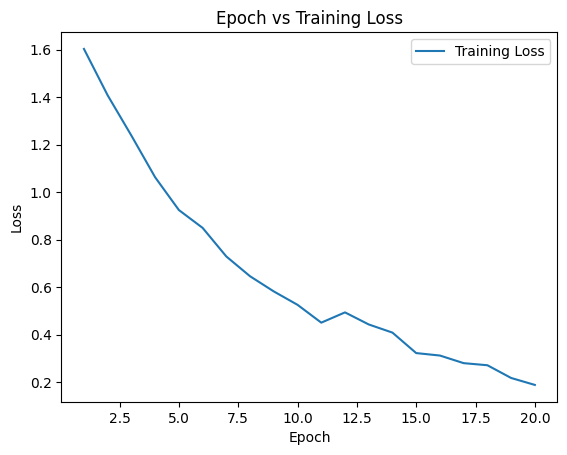

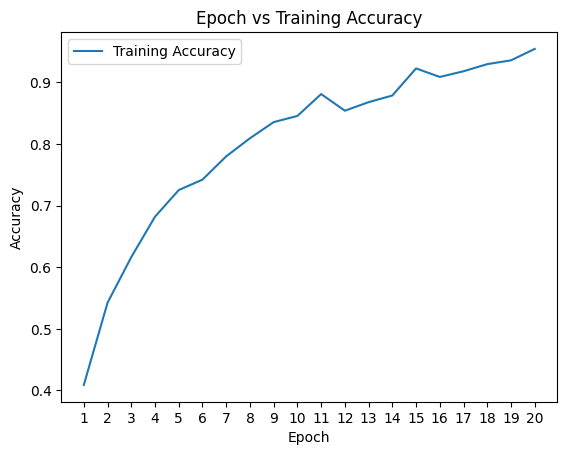

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Epoch vs Training Loss
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(1, len(train_accuracies) + 1)  # Epochs from 1 to the number of epochs
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)  # Ensures x-axis shows every epoch number
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

In [48]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

# Assuming test_loader is already defined as a DataLoader for your test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels": [], "predictions": []}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Assuming the input values are in the format of input_values and attention_mask
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Get predictions (assuming classification with argmax)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate correct predictions and total count
        correct += (preds == labels).sum().item()
        count += labels.size(0)
        
        # Calculate accuracy
        accuracy = correct / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Store the labels and predictions for classification report
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += preds.cpu().numpy().tolist()
        
    pbar.close()

    time.sleep(0.3)
    print(f"The final accuracy on the test dataset: {accuracy * 100:.4f}%")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(record["labels"], record["predictions"], digits=4))


100%|██████████| 144/144 [00:03<00:00, 37.94it/s, loss=0.025, accuracy=0.868]


The final accuracy on the test dataset: 86.8056%

Classification Report:
              precision    recall  f1-score   support

           0     0.7692    0.9091    0.8333        11
           1     0.9444    0.8500    0.8947        20
           2     1.0000    0.9000    0.9474        30
           3     0.8889    0.7619    0.8205        21
           4     0.8636    0.8261    0.8444        23
           5     0.5714    1.0000    0.7273         4
           6     0.7391    0.9444    0.8293        18
           7     0.9375    0.8824    0.9091        17

    accuracy                         0.8681       144
   macro avg     0.8393    0.8842    0.8508       144
weighted avg     0.8848    0.8681    0.8710       144



In [49]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")


Test Accuracy: 0.8681
Test F1 Score: 0.8710
Test Recall: 0.8681
Test Precision: 0.8848


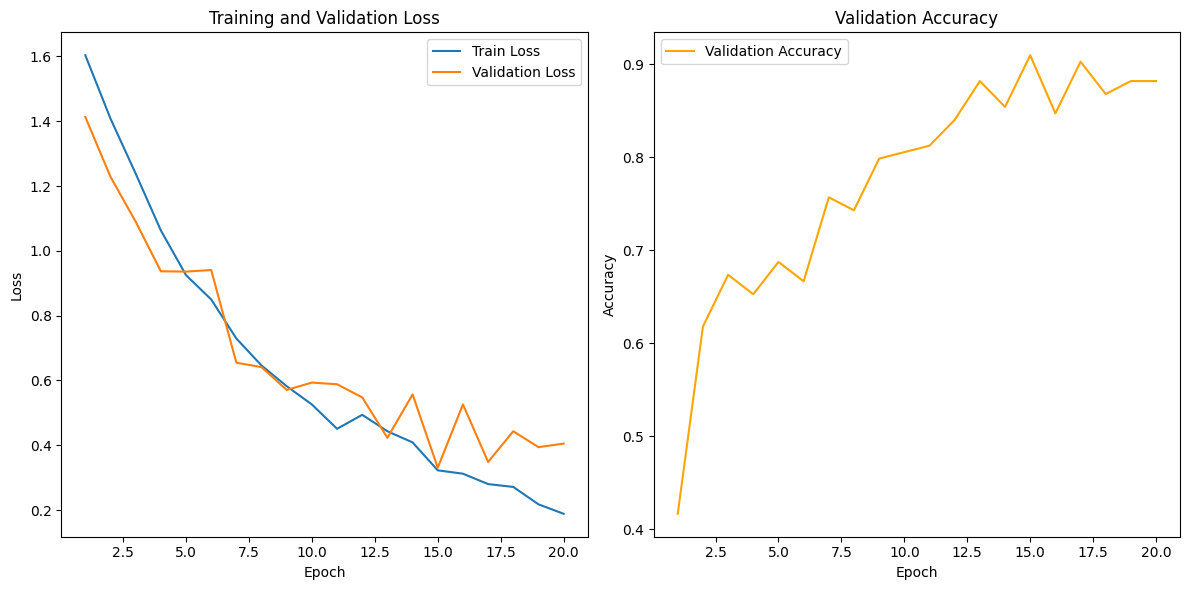

In [50]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()



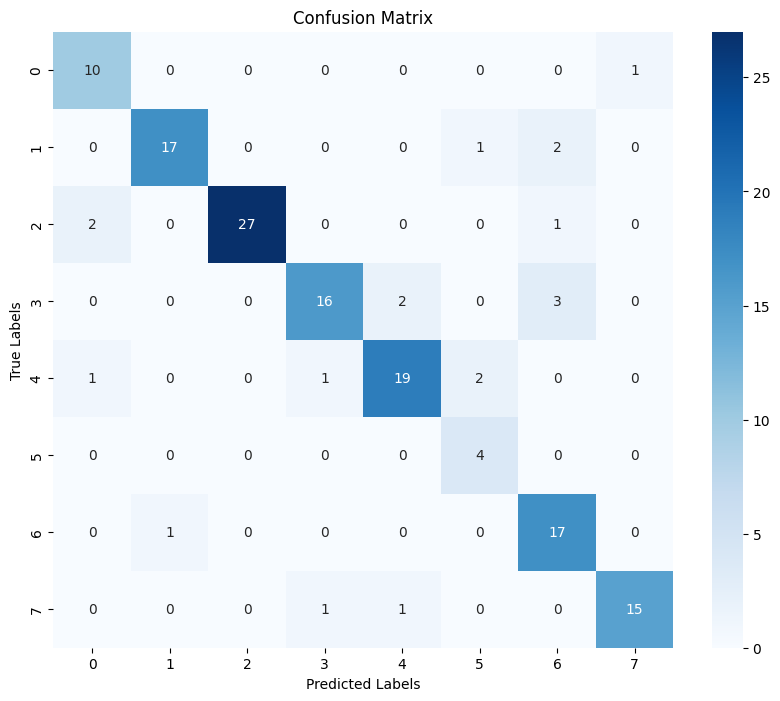

In [51]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

checkpoint_path = '/kaggle/working/model_50_crema.pth'

# Check if the checkpoint exists
if os.path.exists(checkpoint_path):
    # Load checkpoint (model weights and optimizer state)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_accuracies = checkpoint['train_accuracies']
    print(f"Resumed training from epoch {epoch_start + 1}")
else:
    # Start fresh if no checkpoint is found
    epoch_start = 0
    train_loss = []
    train_accuracies = []
    print("No checkpoint found, starting training from scratch.")

model.train()

# Set the number of epochs you want to continue training for
num_epochs = 5

for epoch_i in range(epoch_start, epoch_start + num_epochs):
    print(f'Epoch {epoch_i + 1}/{epoch_start + num_epochs}')
    time.sleep(0.3)
    
    # Create DataLoader for each epoch
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    correct = 0
    count = 0
    epoch_loss = []
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        
        # Move inputs and labels to the device (GPU or CPU)
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # Backward pass
        loss.backward()
        optim.step()
        
        # Prediction and accuracy calculation
        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count
        pbar.set_postfix({'Loss': f'{loss.item():.3f}', 'Accuracy': f'{accuracy:.3f}'})
        
        # Save the loss for the epoch
        epoch_loss.append(loss.item())
    
    pbar.close()
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch_i + 1,  # Save the current epoch number
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'train_loss': train_loss,
        'train_accuracies': train_accuracies,
    }, checkpoint_path)
    print(f"Checkpoint saved for epoch {epoch_i + 1}")

print("Training complete!")
